### Dataset to use - change this value to analyze a different data set

In [1]:
dataset = 'erdos_renyi_final'
nnodes = 25

In [2]:
# from analysis import check_folder
# check_folder.check_folder(dataset)

In [3]:
# import pandas as pd

# def order_tpr_fpr(fprs, tprs):
#     df = pd.DataFrame(dict(fpr=fprs, tpr=tprs))
#     df.sort_values('fpr', ascending=False)
#     df.drop_duplicates(subset='fpr', keep='last', inplace=True)
#     return df
    
    
# a = order_tpr_fpr([.2, .1, .2], [.3, .2, .4])

### Load in parent probabilities and rates

In [4]:
from analysis import check_gies, check_samples
import numpy as np
import itertools as itr
from collections import defaultdict
import xarray as xr
from tqdm import tqdm
import os
import causaldag as cd
from utils import graph_utils
from scipy.special import logsumexp
IV_STRENGTH = .1

In [5]:
# def get_arc_probs(nnodes, dags):
#     poss_arcs = set(itr.permutations(range(nnodes), 2))
#     counts = {arc: 0 for arc in poss_arcs}
#     for dag in dags:
#         for arc in dag.arcs:
#             counts[arc] += 1
#     return {arc: count/len(dags) for arc, count in counts.items()}

In [6]:
# def l1_score_full(arc_probs, true_dag):
#     possible_arcs = set(itr.permutations(true_dag.nodes, 2))
#     nonarcs = possible_arcs - true_dag.arcs
#     return sum(1-arc_probs[arc] for arc in true_dag.arcs) + sum(arc_probs[nonarc] for nonarc in nonarcs)


# def l1_score_fp_full(arc_probs, true_dag):
#     possible_arcs = set(itr.permutations(true_dag.nodes, 2))
#     nonarcs = possible_arcs - true_dag.arcs
#     return sum(arc_probs[nonarc] for nonarc in nonarcs)


# def l1_score_fn_full(arc_probs, gdag):
#     return sum(1-arc_probs[arc] for arc in true_dag.arcs)

In [31]:
dag_folders = check_gies.get_dag_folders(dataset)
true_dags = check_gies.get_true_dags(dag_folders)
covs = [d.covariance for d in true_dags]
true_dags_barren = [cd.DAG(set(dag.nodes), dag.arcs) for dag in true_dags]
true_mecs_barren = [[cd.DAG(true_dag.nodes, arcs) for arcs in true_dag.cpdag().all_dags()] for true_dag in true_dags_barren]
true_mecs = [[graph_utils.cov2dag(cov, d) for d in mec] for mec, cov in zip(true_mecs_barren, covs)]
ndags = len(true_dags)

strategy_names = ['budgeted_exp_design']
ns = [24, 48, 96, 192]
ks = [1, 2, 3]
bs = [1, 2, 3]

In [32]:
interventions_by_dag = [
    [
        cd.BinaryIntervention(
            intervention1=cd.ConstantIntervention(val=-IV_STRENGTH*std),
            intervention2=cd.ConstantIntervention(val=IV_STRENGTH*std),
        ) for std in np.diag(true_dag.covariance)**.5
    ]
    for true_dag in true_dags
]
interventions_by_dag[0]

[BinaryIntervention(intervention1=ConstantIntervention(val=-0.1), intervention2=ConstantIntervention(val=0.1), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-0.14142135623730953), intervention2=ConstantIntervention(val=0.14142135623730953), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-0.14142135623730953), intervention2=ConstantIntervention(val=0.14142135623730953), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-0.17320508075688773), intervention2=ConstantIntervention(val=0.17320508075688773), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-0.1), intervention2=ConstantIntervention(val=0.1), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-0.28284271247461906), intervention2=ConstantIntervention(val=0.28284271247461906), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-0.223606797749979), intervention2=ConstantIntervention(val=0.223606797749979), p=0.5),
 BinaryInte

In [33]:
mec_posteriors = []
for true_dag, true_mec in zip(true_dags, true_mecs):
    da = xr.DataArray(
        np.zeros([len(true_mec), len(strategy_names), len(ns), len(bs), len(ks)]),
        dims=['mec_member', 'strategy', 'n', 'b', 'k'],
        coords={
            'mec_member': list(range(len(true_mec))),
            'strategy': strategy_names,
            'n': ns,
            'b': bs,
            'k': ks
        }
    )
    mec_posteriors.append(da)
print([p.shape for p in mec_posteriors])

[(30, 1, 4, 3, 3), (8, 1, 4, 3, 3), (1, 1, 4, 3, 3), (6, 1, 4, 3, 3), (20, 1, 4, 3, 3), (12, 1, 4, 3, 3), (3, 1, 4, 3, 3), (8, 1, 4, 3, 3), (12, 1, 4, 3, 3), (1, 1, 4, 3, 3), (3, 1, 4, 3, 3), (12, 1, 4, 3, 3), (2, 1, 4, 3, 3), (3, 1, 4, 3, 3), (4, 1, 4, 3, 3), (24, 1, 4, 3, 3), (12, 1, 4, 3, 3), (4, 1, 4, 3, 3), (12, 1, 4, 3, 3), (6, 1, 4, 3, 3), (44, 1, 4, 3, 3), (3, 1, 4, 3, 3), (42, 1, 4, 3, 3), (8, 1, 4, 3, 3), (8, 1, 4, 3, 3), (6, 1, 4, 3, 3), (6, 1, 4, 3, 3), (18, 1, 4, 3, 3), (6, 1, 4, 3, 3), (4, 1, 4, 3, 3), (16, 1, 4, 3, 3), (6, 1, 4, 3, 3), (20, 1, 4, 3, 3), (1, 1, 4, 3, 3), (3, 1, 4, 3, 3), (18, 1, 4, 3, 3), (2, 1, 4, 3, 3), (8, 1, 4, 3, 3), (5, 1, 4, 3, 3), (3, 1, 4, 3, 3), (8, 1, 4, 3, 3), (3, 1, 4, 3, 3), (38, 1, 4, 3, 3), (80, 1, 4, 3, 3), (48, 1, 4, 3, 3), (6, 1, 4, 3, 3), (9, 1, 4, 3, 3), (12, 1, 4, 3, 3), (8, 1, 4, 3, 3), (2, 1, 4, 3, 3)]


In [34]:
for dag_ix, dag_folder, true_dag, true_mec in tqdm(zip(range(ndags), dag_folders, true_dags, true_mecs), total=ndags):
    for strat, n, b, k in itr.product(strategy_names, ns, bs, ks):
        strat_str = '%s,n=%s,b=%s,k=%s' % (strat, n, b, k)
        strat_folder = os.path.join(dag_folder, strat_str)
        if os.path.exists(strat_folder):
            log_posteriors = np.zeros(len(true_mec))

            # == calculate log posteriors based on interventional data
            for iv_node in list(range(nnodes)) + [-1]:
                intervention_fn = os.path.join(dag_folder, strat_str, 'samples', 'intervention=%d.csv' % iv_node)
                if sum(1 for line in open(intervention_fn)) != 0:
                    samples = np.loadtxt(intervention_fn)
                    if len(samples.shape) == 1:
                        samples = np.array([samples])
                    for mec_ix, mec_member in enumerate(true_mec):
                        if iv_node == -1:
                            logpdfs = mec_member.logpdf(samples)
                        else:
                            logpdfs = mec_member.logpdf(samples, {iv_node: interventions_by_dag[dag_ix][iv_node]})
                        log_posteriors[mec_ix] += logpdfs.sum()

            posteriors = np.exp(log_posteriors - logsumexp(log_posteriors))
            if not np.isclose(posteriors.sum(), 1):
                raise ValueError
        mec_posteriors[dag_ix].loc[dict(strategy=strat, n=n, b=b, k=k)] = posteriors

100%|██████████| 50/50 [06:44<00:00,  8.09s/it]


In [11]:
# l1_error_da = xr.DataArray(
#     np.zeros([len(true_dags), len(strategy_names), len(ns), len(bs), len(ks)]),
#     dims=['dag', 'strategy', 'n', 'b', 'k'],
#     coords={
#         'dag': list(range(len(true_dags))),
#         'strategy': strategy_names,
#         'n': ns,
#         'b': bs,
#         'k': ks
#     }
# )
# for dag_ix, true_dag, true_mec in zip(range(len(true_dags)), true_dags, true_mecs):
#     for strat, n, b, k in itr.product(strategy_names, ns, bs, ks):
#         posteriors = mec_posteriors[dag_ix].loc[dict(strategy=strat, n=n, b=b, k=k)]
#         ntrue = 0
#         for mec_member, posterior in zip(true_mec, posteriors):
#             if mec_member.arcs == true_dag.arcs:
#                 ntrue += 1
#                 penalty = 1 - posterior
#             else:
#                 penalty = posterior
#             l1_error_da.loc[dict(dag=dag_ix, strategy=strat, n=n, b=b, k=k)] += penalty
#         if ntrue != 1:
#             raise ValueError

In [12]:
# l1_error_da.shape

In [13]:
# l1_error_da.sel(n=2048, b=1, k=4).mean(dim='dag')

In [14]:
# for n, k, b in itr.product(ns, ks, bs):
#     print(n, k, b)
#     print(l1_error_da.sel(n=n, k=k, b=b).mean(dim='dag').values)

In [15]:
# list(range(5))+[-1]

In [16]:
# counts_da = check_samples.count_samples(dataset, strategy_names, ks, bs, ns)

In [17]:
# rates_da = check_gies.get_rates_data_array(
#     parent_probs_by_dag,
#     true_dags,
#     target=9,
#     strategy_names=strategy_names,
#     ks=ks,
#     bs=bs,
#     ns=ns,
#     alphas=np.linspace(0, 1, 11)
# )
# print(rates_da.dims)

### Plot curves for each strategy

In [35]:
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
%matplotlib inline
plt.rcParams["figure.figsize"] =(20,12)
sns.set(font_scale=1.5)

In [19]:

# linestyles = ['solid', 'dashed', 'dotted']
# colors = sns.color_palette()
# sample_handles = [
#     mlines.Line2D([0], [0], color='k', linestyle=linestyle, label=n) 
#     for n, linestyle in zip(ns, linestyles)
# ]
# strat_handles = [
#     mpatches.Patch(facecolor=color, label=strat)
#     for strat, color in zip(strategy_names, colors)
# ]

In [20]:
# plt.clf()

# rate_avgs_da = rates_da.mean(dim='dag')
# b=1
# k=1
# for strategy, color in zip(strategy_names, colors):
#     for n, linestyle in zip(ns, linestyles):
#         strat_avg_tprs = rate_avgs_da.sel(strategy=strategy, b=b, k=k, n=n, rate='tpr').values
#         strat_avg_fprs = rate_avgs_da.sel(strategy=strategy, b=b, k=k, n=n, rate='fpr').values
#         tpr_fpr_df = order_tpr_fpr(strat_avg_fprs, strat_avg_tprs)
#         plt.plot(tpr_fpr_df['fpr'], tpr_fpr_df['tpr'], linestyle=linestyle, color=color)

# plt.legend(
#     handles=strat_handles + sample_handles
# )
# plt.title(dataset + ', batches=%s, k=%s' % (b, k))
# plt.xlabel('Average FPR')
# plt.ylabel('Average TPR');

In [21]:
# fig, ax = plt.subplots(len(bs), len(ns), sharey=True, sharex=True)
# k=1
# for (b_ix, b), (n_ix, n) in itr.product(list(enumerate(bs)), list(enumerate(ns))):
#     for strategy, color in zip(strategy_names, colors):
#         avg_rates = rate_avgs_da.sel(strategy=strategy, b=b, k=k, n=n)
#         tpr_fpr_df = order_tpr_fpr(avg_rates.sel(rate='fpr').values, avg_rates.sel(rate='tpr').values)
#         ax[b_ix, n_ix].plot(tpr_fpr_df['fpr'], tpr_fpr_df['tpr'], color=color)
#         if b_ix == len(bs)-1:
#             ax[b_ix, n_ix].set_xlabel('n = %s' % n)
#         if n_ix == 0:
#             ax[b_ix, n_ix].set_ylabel('b = %s' % b)


In [36]:
from scipy.stats import entropy

In [23]:
# n = 256
# k = 2
# b = 2

# c_e = counts_da.sel(strategy='entropy', k=k, b=b, n=n)/n
# c_e

In [24]:
# c_r = counts_da.sel(strategy='random', k=k, b=b, n=n)/n

In [41]:
entropy_percent_da = xr.DataArray(
    np.zeros([len(true_dags), len(ns), len(ks)]),
    dims=['dag', 'n', 'k'],
    coords={
        'dag': list(range(len(true_dags))),
        'n': ns,
        'k': ks,
    }
)

In [48]:
for dag_ix, post in enumerate(mec_posteriors):
    for k, n in itr.product(ks, ns):
        p = post.sel(strategy='budgeted_exp_design', k=k, b=1, n=n)
        entropy_percent_da.loc[dict(n=n, k=k, dag=dag_ix)] = (np.log2(len(p)) - entropy(p))/np.log2(len(p))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


(0.3, 1)

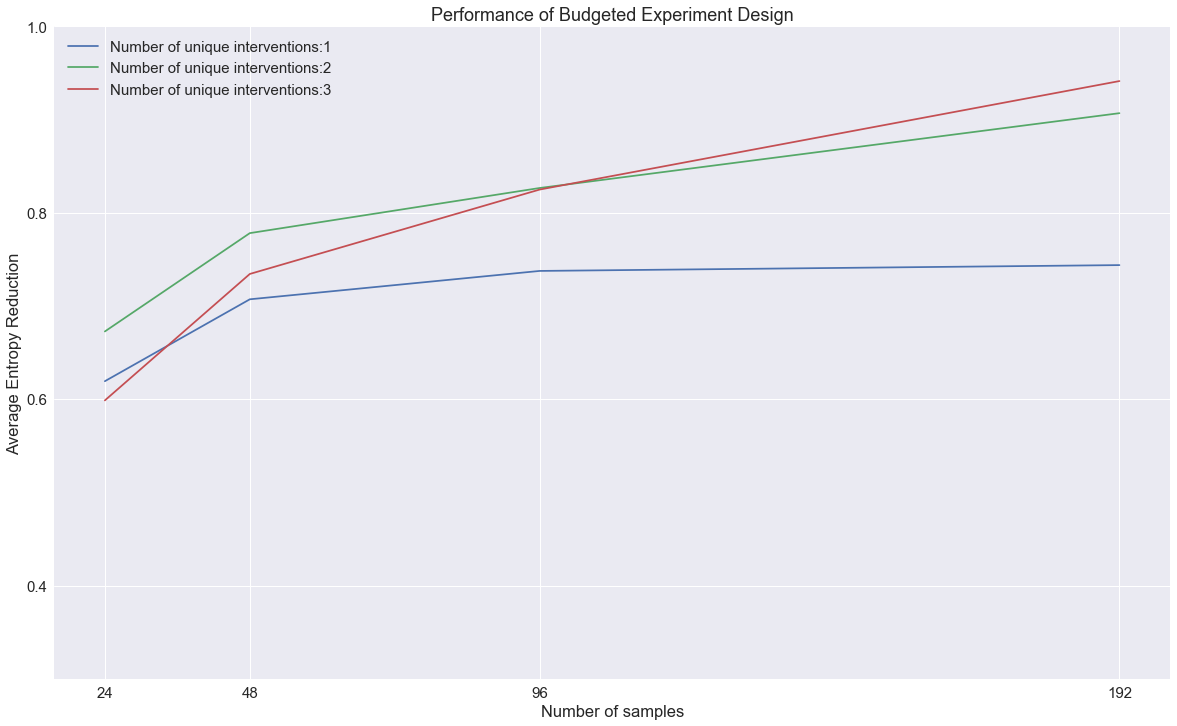

In [56]:
for k in ks:
    entropies = entropy_percent_da.sel(k=k).mean(dim='dag')
    plt.plot(ns, entropies, label='Number of unique interventions:' + str(k))
plt.title('Performance of Budgeted Experiment Design')
plt.ylabel('Average Entropy Reduction')
plt.xlabel('Number of samples')
plt.xticks(ns)
plt.yticks([.4, .6, .8, 1])
plt.legend()
plt.ylim([.3, 1])

In [52]:
entropies.mean(dim='dag')

ValueError: 'dag' not found in array dimensions ('n',)

In [54]:
entropy_percent_da.mean(dim='dag')

<xarray.DataArray (n: 4, k: 3)>
array([[0.619368, 0.672744, 0.598757],
       [0.707247, 0.778249, 0.734428],
       [0.737678, 0.826682, 0.825004],
       [0.743938, 0.906964, 0.941422]])
Coordinates:
  * n        (n) int64 24 48 96 192
  * k        (k) int64 1 2 3